<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Code_9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing of CW-OSL signals: Non-first order kinetics (KP-CW equation)

In the previous chapter we saw the KV-CW equationKV-CW equation, which is based on the GOT model and can be used for CCDA of CW-OSL or CW-IRSL signals:

The KV-CW equation for CW-OSL/CW-IRSL signal analysis ($c>0$) is:
\begin{equation}
I(t)=\frac{A}{W[e^{z}]+W[e^{z}]^{2}}\
\end{equation}


\begin{equation}
z=\frac{1}{c}-\ln(c)+s'\:t\
\end{equation}




The fitting parameters are the effective rate constant $s'$ (in $s^{-1})$ for the OSL process, the scaling constant $A$, the dimensionless positive constant $c>0$ and a constant experimental background $bgd$ (if necessary).

Code 9.2 and the Figure  show the result of the analysis of the same CW-IRSL signal as in the previous section, into one KV-CW component plus a constant background (Pagonis et al. [#Pagonis_2015c]). 

In this example, it is important to use lower and upper bounds for the fitting parameters, so that the least squares algorithm can produce reasonable values for the parameters and their uncertainties. However, in some models one may not need to restrict the parameters by using lower and upper bounds.

The results of Code 9.1 are the frequency factor $s'=1.18\pm0.39$ $s^{-1}$, $c=0.08\pm0.03$, scaling factor $A=200\pm141$, constant background $bgd$ =0.01 and the value of FOM=11 % shows that this fit is acceptable, but it could possibly be improved by using more components to analyze the data. 

However, one notices immediately that the magnitudes of the uncertainties in the fitting parameters are very large, of the order of magnitude of the parameters themselves.

Furthermore, when we attempt to use more than one KV-CW components, we quickly find out that the uncertainties in the least squares fitting routine become extremely large, indicating that in this case the analysis of the data is most likely overdetermined, i.e. too many fitting parameters are being used, and there are infinite combinations of parameter values which can give a good fit to the data.

Another reason that such large uncertainties are obtained in this example, is that the fitting parameters in the KV-CW equation are highly correlated with each other, since they appear in the various mathematical terms as combinations of the original parameters $n_{0}, N, R$ and $s$ in the model.

This example shows the importance of reporting the uncertainties in the values of the best fitting parameters from a least squares fitting procedure. 

FOM= 11.5  %
+----------+--------+------+------+----------+-----------+
| A (a.u.) |   dA   |  c   |  dc  | s (s^-1) | ds (s^-1) |
+----------+--------+------+------+----------+-----------+
|  200.0   | 140.93 | 0.08 | 0.03 |   1.18   |    0.4    |
+----------+--------+------+------+----------+-----------+


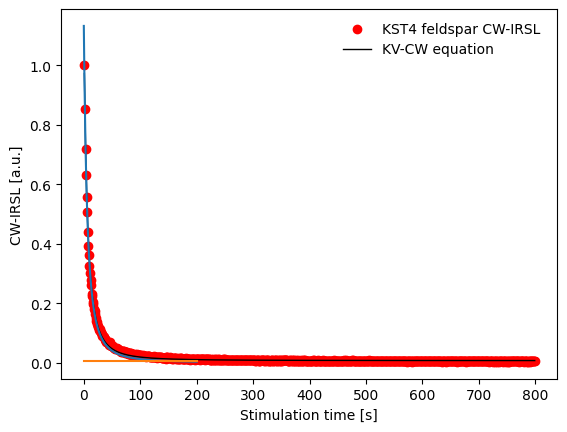

In [1]:
#  deconvolution with KV-CW equation KST4 feldspar CW-IRSL Data 
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from scipy.special import wrightomega 
import warnings
warnings.filterwarnings("ignore")
import requests

# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/KST4ph300IR.TXT'

response = requests.get(url)
a = response.text
b = np.array(list(map(float,a.strip("[]").split())))
data = b.reshape(-1,2)

# select the first 800 points in file
x_data,y_data=data[:,0][1:800], data[:,1][1:800]

# normalize the data

y_data = y_data/max(y_data)

# define KV-CW equation (non-exponential)
def KVCW(t, A,c,sprime):
    zCW=(1/c)-np.log(c)+sprime*t
    lam=wrightomega(zCW)
    CW=A/(lam+lam**2)   
    return CW

# Function to add several components
def total_CW(t, *inis): 
    u=np.array([0 for i in range(len(x_data))])
    As, cs ,sprimes=    inis[0:nPks], inis[nPks:2*nPks],\
    inis[2*nPks:3*nPks]
    bgd=inis[-1]
    for i in range(nPks):        
        u=u+KVCW(t,As[i],cs[i],sprimes[i])
    u=u+bgd 
    return u

t = np.linspace(0, 200, 200)

# nPks is the number of components
nPks=1

# initial values of parameters, with lower and upper bounds

# A parameter
A=[max(y_data)]*nPks
lowA, highA=[0.01*x for x in A], [200 for x in A]

# c parameter
c=[1]*nPks
lowc, highc= [0.001*x for x in c], [1e4*x for x in c]

# s' parameter
sprime=[.1]*nPks 
lowsprime, highsprime=  [0.001*x for x in sprime],\
[100*x for x in sprime]

# bgd parameter
bgd, lowbgd, highbgd=[.1,0,.15]

# all initial values together stored in inis
inis=A+c+sprime+[bgd]

# lower and upper boudns stored together
lowbnds=lowA+lowc+lowsprime+[lowbgd]
highbnds=highA+highc+highsprime+[highbgd]

# find and plot best fit to the data
params, cov = optimize.curve_fit(total_CW,\
x_data,y_data,p0=inis,bounds=(lowbnds,highbnds),maxfev=10000)   
plt.scatter(x_data, y_data,c='r',label='KST4 feldspar CW-IRSL ')
plt.plot(x_data, total_CW(x_data, 
 *params),c='black',label='KV-CW equation',linewidth=1)

# plot each component in CW signal
for i in range(0,nPks): 
    CWi=KVCW(t, params[i],params[nPks+i], params[2*nPks+i])
    plt.plot(t,CWi)
plt.plot(t,[params[-1]]*len(t))
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)  
plt.ylabel('CW-IRSL [a.u.]')
plt.xlabel(r'Stimulation time [s]')

# find residuals and FOM
res=total_CW(x_data, *params)-y_data
FOM=100*np.sum(abs(res))/np.sum(y_data)
print('FOM=',round(FOM,1),' %')

# evaluate parameters and their errors
As=[round(x,2) for x in params[0:nPks]]
cs=[round(x,2) for x in params[nPks:2*nPks]]
sprimes=[round(x,2) for x in params[2*nPks:3*nPks]] 
dAs=[round(np.sqrt(cov[x][x]),2) for x in range(nPks)]
dcs=[round(np.sqrt(cov[x][x]),2) for x in range(nPks,2*nPks)]
dsprimes=[round(np.sqrt(cov[x][x]),2) for x in\
range(2*nPks,3*nPks)]
bgd=round(params[-1],2) 

# print all parameters and errors in a Table
myTable = PrettyTable([ "A (a.u.)","dA",\
'c','dc','s (s^-1)','ds (s^-1)']) 
myTable.add_row([As[0],dAs[0],cs[0],dcs[0],sprimes[0],\
dsprimes[0]])
print(myTable)
plt.show()

# [Return to EURADOS website](https://blog.mcdaniel.edu/vasilispagonis/python-codes-for-eurados-2023/)